## Objective

합성곱 층(CNN)은 영상 내 주요 특징들을 찾아내고 학습합니다. 하지만 각 층이 어떤 패턴을 찾는지는 알기가 어렵습니다. 우리는 각 합성곱 층이 어떤 특징을 찾는지를 추론하기 위해, 각 합성곱 층이 **가장 강하게 반응하는 패턴**을 찾을 것입니다. 필터 시각화라 불리는 이 방법은 각 층에서 은닉층을 가장 활성화시키는 이미지의 패턴을 경사상승법을 통해 찾아가는 방식입니다.

### 필터 시각화를 위한 모델 구현하기

CNN Layer이 학습한 필터를 조사하는 하나의 방법은 각 필터가 반응하는 시각적 패턴을 그리는 것입니다. 빈 입력 이미지에서 시작해서 특정 필터의 출력값을 극대화하기 위해 입력 이미지를 조금씩 바꾼다면, 가장 반응을 크게 하는 패턴을 위주로 입력 이미지가 차츰 변화할 것입니다. Loss 값을 줄이는 방향으로 학습하는 경사하강법과 반대로, 특정 필터의 출력값을 늘리는 방향으로 경사상승법을 적용하게 됩니다.

#### - 모듈 가져오기

필요한 모듈은 아래와 같습니다.

In [ ]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

#### - 탐색할 모형 가져오기

가장 기본적인 모델 중 하나인 VGG 네트워크를 가져오도록 하겠습니다. 케라스에서 지원하는 Pretrained Model로 이미 imagenet으로 기학습된 모형입니다.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=True)

#### - 필터 시각화를 할 출력값 결정하기

우리는 합성곱 층 내 특정 레이어의 특정 필터를 하나 뽑아보도록 하겠습니다. 

In [25]:
from tensorflow.keras.models import Model

conv3_3 = vgg16.get_layer('block3_conv3').output # 3block 내 3th cnn
filter_map = conv3_3[:,:,:,9] 

filter_model = Model(vgg16.inputs, filter_map)

#### - 빈 이미지 구성하기

랜덤 노이즈를 가한 빈 이미지를 구성합니다. 가중치를 초기화할 때 무작위로 추출하는 것처럼, 이 또한 랜덤하게 추출합니다.<br> 

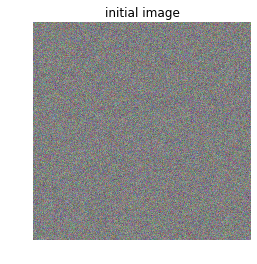

In [26]:
# 무직위 랜덤 이미지
blank = tf.random.normal((1,224,224,3)) * 20 + 128.

initial_image = blank[0].numpy().astype(np.uint8)

plt.title("initial image")
plt.imshow(initial_image)
plt.axis('off')
plt.show()

#### - 출력값이 극대화되도록 이미지를 조금씩 바꾸기

경사하강법과 같이 반복적으로 연산해주면서 바꾸어 줍니다.

In [27]:
learning_rate = 20.
num_step = 100

blank = tf.random.normal((1,224,224,3)) * 20 + 128.
for i in tqdm(range(num_step)):
    with tf.GradientTape() as tape:
        tape.watch(blank)    
        output = filter_model(blank)

    grads = tape.gradient(output, blank) 
    grads = grads / (tf.norm(grads) + 1e-5)
    blank = blank + learning_rate * grads # 경사 상승법

100%|██████████| 100/100 [01:05<00:00,  1.57it/s]


#### - 필터 활성화 이미지를 시각화하기

이를 시각화해보도록 하겠습니다.

In [39]:
def decode_image(image):
    """
    tensor을 normalize 한 후, 이미지로 바꾸어주는 메소드
    """
    image = np.array(image)
    image = image.squeeze() # (1,H,W,C) - >(H,W,C)로 바꾸어줌
    image -= image.mean()
    image /= image.std()
    
    image = (image - image.min())/(image.max()-image.min())
    return image

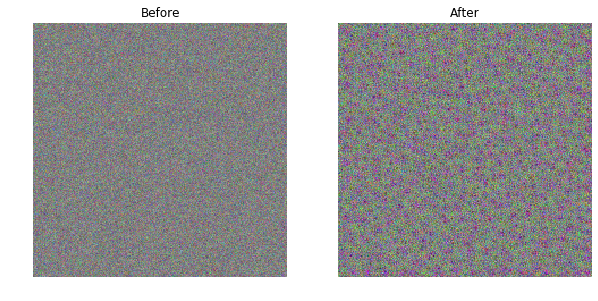

In [38]:
result = decode_image(blank)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("Before")
ax[0].imshow(initial_image)
ax[0].axis('off')

ax[1].set_title("After")
ax[1].imshow(result)
ax[1].axis('off')
plt.show()

#### - 메소드로 구현하기

위 과정을 메소드로 구현하면 아래와 같이 됩니다.

In [45]:
def generate_filter_pattern(model, num_step=100, learning_rate=100):
    blank = tf.random.normal((1,224,224,3)) * 20 + 128.    
    for i in tqdm(range(num_step)):
        with tf.GradientTape() as tape:
            tape.watch(blank)    
            output = model(blank)
        grads = tape.gradient(output, blank) 
        grads = grads / (tf.norm(grads) + 1e-5)
        blank = blank + learning_rate * grads # 경사 상승법       
    
    return decode_image(blank)

100%|██████████| 100/100 [01:30<00:00,  1.02it/s]


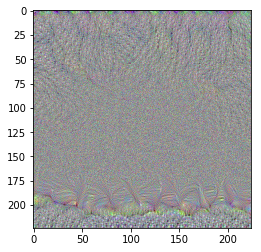

In [46]:
conv4_3 = vgg16.get_layer('block4_conv3').output
filter_model = Model(vgg16.inputs, conv4_3[:,:,:,5])

output = generate_filter_pattern(filter_model, learning_rate=100)
plt.imshow(output)
plt.show()